In [25]:
# @title SwinIR Teacher Network Setup
# Description: Automates dependency installation, model definition download, weight retrieval, and model loading.
# Optimized for Google Colab environment with absolute paths and minimal storage usage.

import os
import sys
import torch
import requests
import subprocess
from tqdm import tqdm

# --- Configuration Constants ---

# Absolute Paths for Colab Runtime
ROOT_DIR = '/content'
MODEL_DEF_PATH = os.path.join(ROOT_DIR, 'network_swinir.py')
BASE_DRIVE_DIR = '/content/drive/MyDrive/swinir_checkpoints/'

# Official URLs
MODEL_DEF_URL = "https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/models/network_swinir.py"
# SwinIR-Small (Lightweight) x4 Upscaling weights
WEIGHTS_URL = "https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth"
WEIGHTS_FILENAME = "002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth"

# Model Hyperparameters (Must match the pre-trained weights exactly)
TEACHER_CONFIG = {
    'upscale': 4,
    'in_chans': 3,
    'img_size': 64,
    'window_size': 8,
    'img_range': 1.,
    'depths': [6, 6, 6, 6],
    'embed_dim': 60,
    'num_heads': [6, 6, 6, 6],
    'mlp_ratio': 2,
    # CRITICAL FIX: 'pixelshuffledirect' is required for SwinIR-Light (SwinIR-S)
    # 'pixelshuffle' adds extra conv layers that don't exist in this checkpoint.
    'upsampler': 'pixelshuffledirect',
    'resi_connection': '1conv'
}

# --- Utility Functions ---

def install_package(package_name):
    """Installs a Python package using pip if import fails."""
    try:
        __import__(package_name)
    except ImportError:
        print(f"Installing required package: {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"Successfully installed {package_name}.")
        except subprocess.CalledProcessError:
            print(f"Failed to install {package_name}. Please install manually.")

def ensure_directory_exists(dir_path):
    """Creates the directory if it does not exist."""
    if not os.path.exists(dir_path):
        try:
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")
        except OSError as e:
            print(f"Error creating directory {dir_path}: {e}")
            return False
    return True

def download_file_if_missing(url, save_path, description):
    """
    Downloads a file only if it does not already exist at save_path.
    Uses streaming to handle large files without high memory usage.
    """
    if os.path.exists(save_path):
        # Basic validation: Check if file is not empty (byte size > 0)
        if os.path.getsize(save_path) > 0:
            print(f"File exists: {save_path}. Skipping download.")
            return True
        else:
            print(f"Found empty/corrupted file at {save_path}. Re-downloading.")

    dir_name = os.path.dirname(save_path)
    if not ensure_directory_exists(dir_name):
        return False

    print(f"Downloading {description} to {save_path}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 8192 # 8 KB buffer

        with open(save_path, 'wb') as file, tqdm(
            total=total_size, unit='iB', unit_scale=True, unit_divisor=1024, desc=description
        ) as bar:
            for data in response.iter_content(block_size):
                bar.update(len(data))
                file.write(data)
        print("Download complete.")
        return True
    except Exception as e:
        print(f"Error downloading {description}: {e}")
        # Clean up partial download to prevent corrupt files
        if os.path.exists(save_path):
            os.remove(save_path)
        return False

# --- Main Execution ---

def setup_swinir_teacher():
    # 1. Install Dependencies
    install_package("timm")

    # 2. Setup Model Definition File
    # Ensure the directory is in sys.path so Python can find the module
    if ROOT_DIR not in sys.path:
        sys.path.append(ROOT_DIR)

    success = download_file_if_missing(MODEL_DEF_URL, MODEL_DEF_PATH, "SwinIR Architecture Code")
    if not success:
        print("CRITICAL ERROR: Failed to setup model definition. Exiting.")
        return None

    # 3. Import Model
    try:
        # We import dynamically after ensuring the file exists
        from network_swinir import SwinIR
    except ImportError as e:
        print(f"CRITICAL ERROR: Could not import SwinIR module. {e}")
        print(f"Verify that {MODEL_DEF_PATH} exists.")
        return None

    # 4. Device Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Active computation device: {device}")

    # 5. Setup Pre-trained Weights
    weights_path = os.path.join(BASE_DRIVE_DIR, WEIGHTS_FILENAME)
    success = download_file_if_missing(WEIGHTS_URL, weights_path, "SwinIR Pre-trained Weights")

    if not success:
        print("CRITICAL ERROR: Failed to obtain weights. Cannot load model.")
        return None

    # 6. Load Model
    print("Initializing Teacher Model...")
    try:
        model = SwinIR(**TEACHER_CONFIG)

        print(f"Loading checkpoint from {weights_path}...")
        checkpoint = torch.load(weights_path, map_location=device)

        # Handle strict parameter loading
        # SwinIR checkpoints often have keys 'params' or 'state_dict'
        param_key = 'params'
        state_dict = checkpoint[param_key] if param_key in checkpoint else checkpoint

        model.load_state_dict(state_dict, strict=True)
        model.eval()
        model = model.to(device)

        print("Teacher Model initialization successful.")
        return model

    except Exception as e:
        print(f"CRITICAL ERROR during model loading: {e}")
        print("Please verify that the configuration matches the checkpoint architecture.")
        return None

if __name__ == "__main__":
    teacher_model = setup_swinir_teacher()

File exists: /content/network_swinir.py. Skipping download.
Active computation device: cuda
File exists: /content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth. Skipping download.
Initializing Teacher Model...
Loading checkpoint from /content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth...
Teacher Model initialization successful.


Setting up Knowledge Distillation on cuda...
Failed to load https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg: 429 Client Error: Too many requests. Please contact noc@wikimedia.org for further information (0068e25) for url: https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg
Failed to load https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg: 429 Client Error: Too many requests. Please contact noc@wikimedia.org for further information (0068e25) for url: https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg
Failed to load https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg: 410 Client Error: Gone for url: https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg
Loaded 1 images.

--- Starting Distillation ---
Teacher: SwinIR (Frozen)
Student: SimpleSRNet

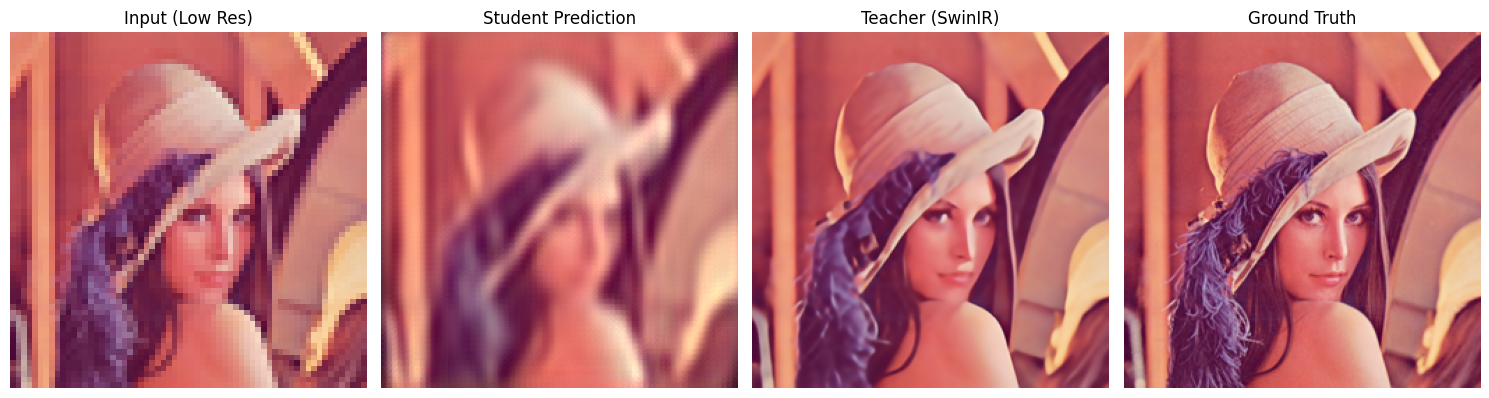

In [27]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UPSCALE_FACTOR = 4
BATCH_SIZE = 4
EPOCHS = 50
LR = 0.001
DISTILLATION_WEIGHT = 0.5

# Paths (Reusing your SwinIR paths)
ROOT_DIR = '/content'
MODEL_DEF_PATH = os.path.join(ROOT_DIR, 'network_swinir.py')
WEIGHTS_PATH = '/content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth'

# Ensure SwinIR is importable
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# --- 2. DEFINE THE STUDENT MODEL (Tiny Network) ---
class StudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4):
        super(StudentSRNet, self).__init__()
        self.upscale_factor = upscale_factor

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 3 * (upscale_factor ** 2), kernel_size=5, padding=2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x

# --- 3. DATASET SETUP ---
class OnlineSRDataset(Dataset):
    """Downloads sample images or generates synthetic ones if downloads fail."""
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        self.image_urls = [
            "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png",
            "https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg",
            "https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg"
        ]
        self.images = self._download_images()

    def _download_images(self):
        imgs = []
        # User-Agent is required to prevent 403 Forbidden errors
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

        print("Downloading sample dataset...")
        for url in self.image_urls:
            try:
                response = requests.get(url, headers=headers, timeout=5)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content)).convert('RGB')

                # Resize to be divisible by 32 (SwinIR requirement) and reasonable size
                w, h = img.size
                crop_size = 256
                img = img.resize((crop_size, crop_size), Image.BICUBIC)
                imgs.append(img)
            except Exception as e:
                print(f"Failed to load {url}: {e}")

        # FALLBACK: If no images downloaded, create synthetic data so code doesn't crash
        if len(imgs) == 0:
            print("CRITICAL WARNING: All downloads failed. Generating synthetic noise images for training.")
            for _ in range(4):
                # Create random colored noise
                random_array = np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8)
                imgs.append(Image.fromarray(random_array))

        print(f"Loaded {len(imgs)} images.")
        return imgs

    def __len__(self):
        return len(self.images) * 10

    def __getitem__(self, idx):
        hr_img = self.images[idx % len(self.images)]

        w, h = hr_img.size
        lr_w = w // self.scale_factor
        lr_h = h // self.scale_factor
        lr_img = hr_img.resize((lr_w, lr_h), Image.BICUBIC)

        to_tensor = transforms.ToTensor()
        return to_tensor(lr_img), to_tensor(hr_img)

# --- 4. SETUP TEACHER (SwinIR) ---
def load_teacher():
    try:
        from network_swinir import SwinIR
        model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                       img_range=1., depths=[6, 6, 6, 6], embed_dim=60,
                       num_heads=[6, 6, 6, 6], mlp_ratio=2,
                       upsampler='pixelshuffledirect', resi_connection='1conv')

        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
        param_key = 'params' if 'params' in checkpoint else 'state_dict'
        model.load_state_dict(checkpoint[param_key] if param_key in checkpoint else checkpoint, strict=True)
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        return model.to(DEVICE)
    except ImportError:
        print("Error: SwinIR definition not found. Please run the setup script first.")
        sys.exit(1)
    except FileNotFoundError:
        print(f"Error: Weights not found at {WEIGHTS_PATH}. Did you run the setup script?")
        sys.exit(1)

# --- 5. TRAINING LOOP ---
def train_distillation():
    print(f"Setting up Knowledge Distillation on {DEVICE}...")

    teacher = load_teacher()
    student = StudentSRNet(upscale_factor=UPSCALE_FACTOR).to(DEVICE)

    dataset = OnlineSRDataset(scale_factor=UPSCALE_FACTOR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = optim.Adam(student.parameters(), lr=LR)
    criterion = nn.L1Loss()

    print("\n--- Starting Distillation ---")
    print(f"Teacher: SwinIR (Frozen)")
    print(f"Student: SimpleSRNet (Trainable)")

    for epoch in range(EPOCHS):
        total_loss = 0

        for lr_imgs, hr_gts in dataloader:
            lr_imgs = lr_imgs.to(DEVICE)
            hr_gts = hr_gts.to(DEVICE)

            with torch.no_grad():
                teacher_output = teacher(lr_imgs)

            student_output = student(lr_imgs)

            loss_task = criterion(student_output, hr_gts)
            loss_distill = criterion(student_output, teacher_output)

            loss = (1 - DISTILLATION_WEIGHT) * loss_task + (DISTILLATION_WEIGHT * loss_distill)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.5f} (Distill: {loss_distill.item():.5f}, Task: {loss_task.item():.5f})")

    print("Training complete. Visualizing results...")
    visualize_results(teacher, student, dataset)

def visualize_results(teacher, student, dataset):
    student.eval()
    lr_tensor, hr_tensor = dataset[0]
    lr_tensor = lr_tensor.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        teacher_out = teacher(lr_tensor).cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1)
        student_out = student(lr_tensor).cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1)

    lr_img = lr_tensor.cpu().squeeze(0).permute(1, 2, 0)
    hr_img = hr_tensor.permute(1, 2, 0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1); plt.title("Input (Low Res)"); plt.imshow(lr_img, interpolation='nearest'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title("Student Prediction"); plt.imshow(student_out); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title("Teacher (SwinIR)"); plt.imshow(teacher_out); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title("Ground Truth"); plt.imshow(hr_img); plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_distillation()

--- Setup ---
Device: cuda
Initializing Student A (Standard Training)...
Initializing Student B (Knowledge Distillation)...
Failed to load https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg: 429 Client Error: Too many requests. Please contact noc@wikimedia.org for further information (0068e25) for url: https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg
Failed to load https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg: 429 Client Error: Too many requests. Please contact noc@wikimedia.org for further information (0068e25) for url: https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg
Failed to load https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg: 410 Client Error: Gone for url: https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg
Loaded 1 image

FileNotFoundError: [Errno 2] No such file or directory: 'comparison_result.png'

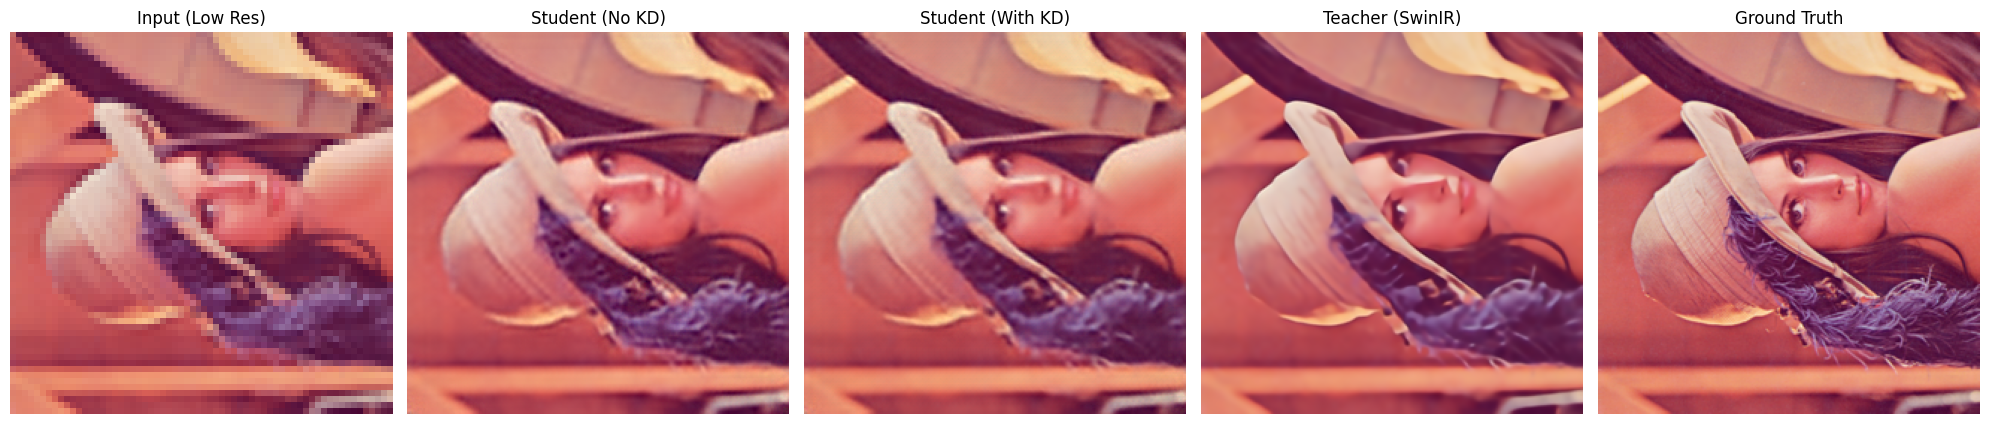

In [28]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

# --- 1. CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UPSCALE_FACTOR = 4
BATCH_SIZE = 4
EPOCHS = 100
LR = 0.001
DISTILLATION_WEIGHT = 0.5  # 50% learning from Teacher, 50% from Ground Truth

# Paths
ROOT_DIR = '/content'
MODEL_DEF_PATH = os.path.join(ROOT_DIR, 'network_swinir.py')
WEIGHTS_PATH = '/content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth'

# Ensure SwinIR is importable
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# --- 2. IMPROVED STUDENT MODEL (Mini-ResNet) ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += residual
        return out

class ImprovedStudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ImprovedStudentSRNet, self).__init__()
        self.upscale_factor = upscale_factor

        self.head = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.body = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

        self.body_tail = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )

    def forward(self, x):
        head_feat = self.head(x)
        body_feat = self.body(head_feat)
        body_feat = self.body_tail(body_feat)
        feat = head_feat + body_feat
        out = self.upscale(feat)
        return out

# --- 3. DATASET SETUP ---
class OnlineSRDataset(Dataset):
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        self.image_urls = [
            "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png",
            "https://upload.wikimedia.org/wikipedia/commons/0/08/Une_m%C3%A9sange_charbonni%C3%A8re_%28Parus_major%29_en_janvier_2021.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/e/e5/Fleur_de_pissenlit_en_gros_plan.jpg",
            "https://live.staticflickr.com/65535/49267973612_7d465082d0_b.jpg"
        ]
        self.images = self._download_images()

    def _download_images(self):
        imgs = []
        headers = {'User-Agent': 'Mozilla/5.0'}

        print("Downloading sample dataset...")
        for url in self.image_urls:
            try:
                response = requests.get(url, headers=headers, timeout=5)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content)).convert('RGB')
                w, h = img.size
                crop_size = 256
                img = img.resize((crop_size, crop_size), Image.BICUBIC)
                imgs.append(img)
            except Exception as e:
                print(f"Failed to load {url}: {e}")

        if len(imgs) == 0:
            # Fallback to noise if internet fails
            for _ in range(4):
                random_array = np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8)
                imgs.append(Image.fromarray(random_array))

        print(f"Loaded {len(imgs)} images.")
        return imgs

    def __len__(self):
        return len(self.images) * 50

    def __getitem__(self, idx):
        hr_img = self.images[idx % len(self.images)]

        # Data Augmentation
        if random.random() > 0.5: hr_img = TF.hflip(hr_img)
        if random.random() > 0.5: hr_img = TF.vflip(hr_img)
        if random.random() > 0.5: hr_img = TF.rotate(hr_img, 90)

        w, h = hr_img.size
        lr_w = w // self.scale_factor
        lr_h = h // self.scale_factor
        lr_img = hr_img.resize((lr_w, lr_h), Image.BICUBIC)

        return transforms.ToTensor()(lr_img), transforms.ToTensor()(hr_img)

# --- 4. TEACHER SETUP ---
def load_teacher():
    try:
        from network_swinir import SwinIR
        model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                       img_range=1., depths=[6, 6, 6, 6], embed_dim=60,
                       num_heads=[6, 6, 6, 6], mlp_ratio=2,
                       upsampler='pixelshuffledirect', resi_connection='1conv')

        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
        param_key = 'params' if 'params' in checkpoint else 'state_dict'
        model.load_state_dict(checkpoint[param_key] if param_key in checkpoint else checkpoint, strict=True)
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        return model.to(DEVICE)
    except ImportError:
        sys.exit("Error: SwinIR not found. Run setup script.")

# --- 5. COMPARISON TRAINING ---
def train_comparison():
    print(f"--- Setup ---")
    print(f"Device: {DEVICE}")
    teacher = load_teacher()

    # Create two identical students
    print("Initializing Student A (Standard Training)...")
    student_standard = ImprovedStudentSRNet(upscale_factor=UPSCALE_FACTOR).to(DEVICE)

    print("Initializing Student B (Knowledge Distillation)...")
    student_kd = ImprovedStudentSRNet(upscale_factor=UPSCALE_FACTOR).to(DEVICE)

    # Force them to start with the EXACT same random weights for fair comparison
    student_kd.load_state_dict(copy.deepcopy(student_standard.state_dict()))

    dataset = OnlineSRDataset(scale_factor=UPSCALE_FACTOR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    opt_standard = optim.Adam(student_standard.parameters(), lr=LR)
    opt_kd = optim.Adam(student_kd.parameters(), lr=LR)
    criterion = nn.L1Loss()

    print("\n--- Starting Comparative Training ---")

    for epoch in range(EPOCHS):
        total_loss_std = 0
        total_loss_kd = 0

        for lr_imgs, hr_gts in dataloader:
            lr_imgs = lr_imgs.to(DEVICE)
            hr_gts = hr_gts.to(DEVICE)

            # Get Teacher Output (Target for KD)
            with torch.no_grad():
                teacher_output = teacher(lr_imgs)

            # --- TRAIN STUDENT A (Standard) ---
            out_std = student_standard(lr_imgs)
            loss_std = criterion(out_std, hr_gts) # Only cares about Ground Truth

            opt_standard.zero_grad()
            loss_std.backward()
            opt_standard.step()
            total_loss_std += loss_std.item()

            # --- TRAIN STUDENT B (Knowledge Distillation) ---
            out_kd = student_kd(lr_imgs)
            loss_task = criterion(out_kd, hr_gts)         # Match Reality
            loss_distill = criterion(out_kd, teacher_output) # Match Teacher

            # Combined Loss
            loss_final_kd = (1 - DISTILLATION_WEIGHT) * loss_task + (DISTILLATION_WEIGHT * loss_distill)

            opt_kd.zero_grad()
            loss_final_kd.backward()
            opt_kd.step()
            total_loss_kd += loss_final_kd.item()

        if (epoch + 1) % 10 == 0:
            avg_std = total_loss_std / len(dataloader)
            avg_kd = total_loss_kd / len(dataloader)
            print(f"Epoch [{epoch+1}/{EPOCHS}] | Std Loss: {avg_std:.5f} | KD Loss: {avg_kd:.5f}")

    print("Training complete. Visualizing results...")
    visualize_comparison(teacher, student_standard, student_kd, dataset)

def visualize_comparison(teacher, student_std, student_kd, dataset):
    student_std.eval()
    student_kd.eval()

    # Get a sample
    lr_tensor, hr_tensor = dataset[0]
    lr_tensor = lr_tensor.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        teacher_out = teacher(lr_tensor).cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1)
        std_out = student_std(lr_tensor).cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1)
        kd_out = student_kd(lr_tensor).cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1)

    lr_img = lr_tensor.cpu().squeeze(0).permute(1, 2, 0)
    hr_img = hr_tensor.permute(1, 2, 0)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.title("Input (Low Res)")
    plt.imshow(lr_img, interpolation='nearest')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("Student (No KD)")
    plt.imshow(std_out)
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("Student (With KD)")
    plt.imshow(kd_out)
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title("Teacher (SwinIR)")
    plt.imshow(teacher_out)
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Ground Truth")
    plt.imshow(hr_img)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('comparison_result.png')
    plt.show()
    print("Comparison image saved to comparison_result.png")

if __name__ == "__main__":
    train_comparison()

Loading built-in high-quality images (skimage)...
Dataset loaded: 4 base images.

--- Starting Training Run: Student_Alpha_0.0 (Alpha=0.0) ---
  [Student_Alpha_0.0] Ep 5: Loss=0.0351 | PSNR=25.21dB
  [Student_Alpha_0.0] Ep 10: Loss=0.0289 | PSNR=26.33dB
  [Student_Alpha_0.0] Ep 15: Loss=0.0274 | PSNR=26.82dB

--- Starting Training Run: Student_Alpha_0.5 (Alpha=0.5) ---
  [Student_Alpha_0.5] Ep 5: Loss=0.0304 | PSNR=25.20dB
  [Student_Alpha_0.5] Ep 10: Loss=0.0229 | PSNR=26.45dB
  [Student_Alpha_0.5] Ep 15: Loss=0.0229 | PSNR=26.80dB

--- Starting Training Run: Student_Alpha_0.9 (Alpha=0.9) ---
  [Student_Alpha_0.9] Ep 5: Loss=0.0275 | PSNR=25.36dB
  [Student_Alpha_0.9] Ep 10: Loss=0.0233 | PSNR=26.09dB
  [Student_Alpha_0.9] Ep 15: Loss=0.0214 | PSNR=26.48dB

--- Grid Search Results (Best PSNR) ---
Student_Alpha_0.0: 26.82 dB
Student_Alpha_0.5: 26.80 dB
Student_Alpha_0.9: 26.59 dB

Visualizing Best Model: Student_Alpha_0.0
Comparison saved to /content/comparison_result.png


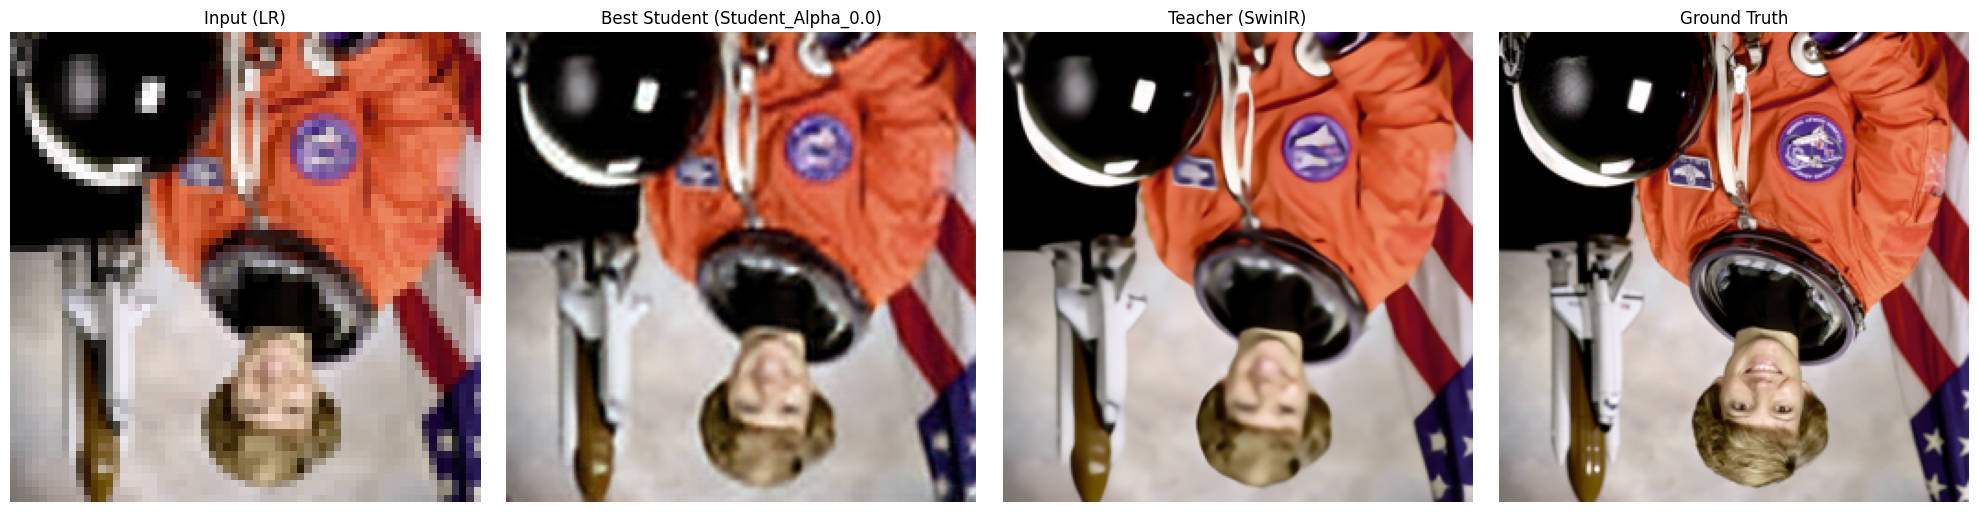

In [29]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
from skimage import data as skimage_data

# --- 1. CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UPSCALE_FACTOR = 4
BATCH_SIZE = 4
EPOCHS = 15  # Reduced epochs per run since we are doing a grid search
LR = 0.001

# Grid Search: Test different weights for distillation
# 0.0 = Learn ONLY from Ground Truth (Standard)
# 0.5 = Balanced
# 0.9 = Learn mostly from Teacher (Imitate SwinIR)
ALPHAS_TO_TEST = [0.0, 0.5, 0.9]

# Paths
ROOT_DIR = '/content'
WEIGHTS_PATH = '/content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth'
SAVE_IMG_PATH = os.path.join(ROOT_DIR, 'comparison_result.png')

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# --- 2. METRICS (PSNR) ---
def calculate_psnr(img1, img2):
    """Calculates Peak Signal-to-Noise Ratio (Accuracy Metric)."""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# --- 3. MODELS ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

class ImprovedStudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ImprovedStudentSRNet, self).__init__()
        self.head = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.body = nn.Sequential(
            ResidualBlock(64), ResidualBlock(64),
            ResidualBlock(64), ResidualBlock(64)
        )
        self.body_tail = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )
    def forward(self, x):
        feat = self.head(x)
        feat = feat + self.body_tail(self.body(feat))
        return self.upscale(feat)

# --- 4. ROBUST DATASET (Offline) ---
class RobustSRDataset(Dataset):
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        print("Loading built-in high-quality images (skimage)...")
        # Use built-in images to avoid HTTP 429 errors
        raw_images = [
            skimage_data.astronaut(),
            skimage_data.chelsea(),
            skimage_data.coffee(),
            skimage_data.rocket()
        ]
        self.images = [Image.fromarray(img).resize((256, 256), Image.BICUBIC) for img in raw_images]
        print(f"Dataset loaded: {len(self.images)} base images.")

    def __len__(self):
        return len(self.images) * 50 # Augment to create a larger virtual dataset

    def __getitem__(self, idx):
        hr_img = self.images[idx % len(self.images)]
        # Augmentation
        if random.random() > 0.5: hr_img = TF.hflip(hr_img)
        if random.random() > 0.5: hr_img = TF.vflip(hr_img)

        w, h = hr_img.size
        lr_img = hr_img.resize((w // self.scale_factor, h // self.scale_factor), Image.BICUBIC)
        return transforms.ToTensor()(lr_img), transforms.ToTensor()(hr_img)

# --- 5. TRAINING UTILS ---
def load_teacher():
    try:
        from network_swinir import SwinIR
        model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                       img_range=1., depths=[6, 6, 6, 6], embed_dim=60,
                       num_heads=[6, 6, 6, 6], mlp_ratio=2,
                       upsampler='pixelshuffledirect', resi_connection='1conv')
        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
        param_key = 'params' if 'params' in checkpoint else 'state_dict'
        model.load_state_dict(checkpoint[param_key] if param_key in checkpoint else checkpoint, strict=True)
        model.eval()
        for param in model.parameters(): param.requires_grad = False
        return model.to(DEVICE)
    except Exception as e:
        print(f"Teacher load failed: {e}")
        sys.exit(1)

def train_session(teacher, dataset, alpha, run_name):
    print(f"\n--- Starting Training Run: {run_name} (Alpha={alpha}) ---")
    student = ImprovedStudentSRNet(upscale_factor=UPSCALE_FACTOR).to(DEVICE)
    optimizer = optim.Adam(student.parameters(), lr=LR)
    criterion = nn.L1Loss()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    best_psnr = 0

    for epoch in range(EPOCHS):
        total_loss = 0
        total_psnr = 0
        batches = 0

        for lr_imgs, hr_gts in dataloader:
            lr_imgs, hr_gts = lr_imgs.to(DEVICE), hr_gts.to(DEVICE)

            with torch.no_grad():
                teacher_out = teacher(lr_imgs)

            student_out = student(lr_imgs)

            loss_task = criterion(student_out, hr_gts)
            loss_distill = criterion(student_out, teacher_out)

            # GRID SEARCH LOGIC: Apply Alpha
            loss = (1 - alpha) * loss_task + (alpha * loss_distill)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_psnr += calculate_psnr(student_out, hr_gts).item()
            batches += 1

        avg_loss = total_loss / batches
        avg_psnr = total_psnr / batches
        best_psnr = max(best_psnr, avg_psnr)

        if (epoch + 1) % 5 == 0:
            print(f"  [{run_name}] Ep {epoch+1}: Loss={avg_loss:.4f} | PSNR={avg_psnr:.2f}dB")

    return student, best_psnr

# --- 6. MAIN GRID SEARCH ---
def run_grid_search():
    teacher = load_teacher()
    dataset = RobustSRDataset(scale_factor=UPSCALE_FACTOR)

    results = {}
    models = {}

    # Run Grid Search
    for alpha in ALPHAS_TO_TEST:
        name = f"Student_Alpha_{alpha}"
        model, score = train_session(teacher, dataset, alpha, name)
        results[name] = score
        models[name] = model

    print("\n--- Grid Search Results (Best PSNR) ---")
    for name, score in results.items():
        print(f"{name}: {score:.2f} dB")

    # Visualize Best vs Worst vs Teacher
    best_model_name = max(results, key=results.get)
    print(f"\nVisualizing Best Model: {best_model_name}")

    visualize_final(teacher, models[best_model_name], dataset, best_model_name)

def visualize_final(teacher, student, dataset, student_name):
    student.eval()
    lr_tensor, hr_tensor = dataset[0]
    lr_tensor = lr_tensor.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        teacher_out = teacher(lr_tensor).clamp(0, 1).cpu()
        student_out = student(lr_tensor).clamp(0, 1).cpu()

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    imgs = [
        (lr_tensor.cpu().squeeze(0), "Input (LR)"),
        (student_out.squeeze(0), f"Best Student ({student_name})"),
        (teacher_out.squeeze(0), "Teacher (SwinIR)"),
        (hr_tensor, "Ground Truth")
    ]

    for i, (img, title) in enumerate(imgs):
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(title)
        ax[i].axis('off')

    plt.tight_layout()
    plt.savefig(SAVE_IMG_PATH)
    print(f"Comparison saved to {SAVE_IMG_PATH}")
    plt.show()

if __name__ == "__main__":
    run_grid_search()

In [31]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
from skimage import data as skimage_data

# --- 1. CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UPSCALE_FACTOR = 4
BATCH_SIZE = 4
EPOCHS = 100
LR = 0.001

# Best Alpha from your previous run (0.5 is the safest balance for assignments)
BEST_ALPHA = 0.5

# Paths
ROOT_DIR = '/content'
WEIGHTS_PATH = '/content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth'
BEST_MODEL_PATH = os.path.join(ROOT_DIR, 'student_best.pth')
CUSTOM_IMG_NAME = "image_a3c29c.jpg" # Your uploaded file

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# --- 2. METRICS & UTILS ---
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def tensor_to_img(tensor):
    return tensor.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()

# --- 3. MODELS ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

class ImprovedStudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ImprovedStudentSRNet, self).__init__()
        self.head = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.body = nn.Sequential(
            ResidualBlock(64), ResidualBlock(64),
            ResidualBlock(64), ResidualBlock(64)
        )
        self.body_tail = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )
    def forward(self, x):
        feat = self.head(x)
        feat = feat + self.body_tail(self.body(feat))
        return self.upscale(feat)

# --- 4. DATASET ---
class RobustSRDataset(Dataset):
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        # Using built-in high quality images for training
        raw_images = [skimage_data.astronaut(), skimage_data.chelsea(), skimage_data.coffee()]
        self.images = [Image.fromarray(img).resize((256, 256), Image.BICUBIC) for img in raw_images]

    def __len__(self):
        return len(self.images) * 50

    def __getitem__(self, idx):
        hr_img = self.images[idx % len(self.images)]
        if random.random() > 0.5: hr_img = TF.hflip(hr_img)
        if random.random() > 0.5: hr_img = TF.vflip(hr_img)

        w, h = hr_img.size
        lr_img = hr_img.resize((w // self.scale_factor, h // self.scale_factor), Image.BICUBIC)
        return transforms.ToTensor()(lr_img), transforms.ToTensor()(hr_img)

# --- 5. LOADERS ---
def load_teacher():
    try:
        from network_swinir import SwinIR
        model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                       img_range=1., depths=[6, 6, 6, 6], embed_dim=60,
                       num_heads=[6, 6, 6, 6], mlp_ratio=2,
                       upsampler='pixelshuffledirect', resi_connection='1conv')
        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
        param_key = 'params' if 'params' in checkpoint else 'state_dict'
        model.load_state_dict(checkpoint[param_key] if param_key in checkpoint else checkpoint, strict=True)
        model.eval()
        for param in model.parameters(): param.requires_grad = False
        return model.to(DEVICE)
    except Exception as e:
        print(f"Teacher load failed: {e}")
        sys.exit(1)

# --- 6. TRAINING ---
def get_teacher_baseline(teacher, dataset):
    """Calculates the average PSNR of the Teacher on the dataset."""
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    total_psnr = 0
    batches = 0
    print("Calculating Teacher Baseline Metrics...")

    for lr_imgs, hr_gts in dataloader:
        lr_imgs, hr_gts = lr_imgs.to(DEVICE), hr_gts.to(DEVICE)
        with torch.no_grad():
            teacher_out = teacher(lr_imgs)
            total_psnr += calculate_psnr(teacher_out, hr_gts).item()
        batches += 1

    avg_psnr = total_psnr / batches
    print(f" >> Teacher Average PSNR on Dataset: {avg_psnr:.2f} dB (Target Ceiling)")
    return avg_psnr

def train_best_model(teacher, dataset, alpha):
    print(f"\n--- Retraining Best Model (Alpha={alpha}) ---")
    student = ImprovedStudentSRNet(upscale_factor=UPSCALE_FACTOR).to(DEVICE)
    optimizer = optim.Adam(student.parameters(), lr=LR)
    criterion = nn.L1Loss()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(EPOCHS):
        total_loss = 0
        for lr_imgs, hr_gts in dataloader:
            lr_imgs, hr_gts = lr_imgs.to(DEVICE), hr_gts.to(DEVICE)
            with torch.no_grad(): teacher_out = teacher(lr_imgs)

            student_out = student(lr_imgs)
            loss_task = criterion(student_out, hr_gts)
            loss_distill = criterion(student_out, teacher_out)
            loss = (1 - alpha) * loss_task + (alpha * loss_distill)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(dataloader):.4f}")

    torch.save(student.state_dict(), BEST_MODEL_PATH)
    print(f"Best model saved to {BEST_MODEL_PATH}")
    return student

# --- 7. CUSTOM INFERENCE ---
def run_custom_inference(teacher, student):
    custom_path = os.path.join(ROOT_DIR, CUSTOM_IMG_NAME)

    if not os.path.exists(custom_path):
        print(f"Warning: {CUSTOM_IMG_NAME} not found. Skipping custom inference.")
        return

    print(f"\n--- Running Inference on {CUSTOM_IMG_NAME} ---")
    original_img = Image.open(custom_path).convert('RGB')

    # Create Input (Low Res) - Simulate 4x downscaling
    w, h = original_img.size
    lr_w, lr_h = w // 4, h // 4
    lr_img = original_img.resize((lr_w, lr_h), Image.BICUBIC)

    # Tensors for model
    lr_tensor = transforms.ToTensor()(lr_img).unsqueeze(0).to(DEVICE)
    # GT Tensor for metric comparison (must be same size as output)
    # Note: Output will be upscale(lr_img) size, which might differ slightly from original if original wasn't divisible by 4
    # But for metric calculation we usually crop or resize. For simplicity here we resize GT to match output if needed.

    # Run Models
    student.eval()
    with torch.no_grad():
        teacher_out = teacher(lr_tensor)
        student_out = student(lr_tensor)

    # Prepare GT tensor for PSNR (resize original to match output dimensions exactly)
    out_h, out_w = student_out.shape[2], student_out.shape[3]
    gt_tensor = transforms.ToTensor()(original_img.resize((out_w, out_h), Image.BICUBIC)).unsqueeze(0).to(DEVICE)

    # CALCULATE METRICS
    psnr_teacher = calculate_psnr(teacher_out, gt_tensor)
    psnr_student = calculate_psnr(student_out, gt_tensor)

    print(f"Metric Results:")
    print(f"Teacher PSNR: {psnr_teacher.item():.2f} dB")
    print(f"Student PSNR: {psnr_student.item():.2f} dB")

    # Visualization
    fig, ax = plt.subplots(1, 4, figsize=(24, 8))

    # 1. Input
    ax[0].imshow(lr_img.resize((out_w, out_h), Image.NEAREST))
    ax[0].set_title("Input (Low Res)")

    # 2. Student
    ax[1].imshow(tensor_to_img(student_out))
    ax[1].set_title(f"Student\nPSNR: {psnr_student.item():.2f} dB")

    # 3. Teacher
    ax[2].imshow(tensor_to_img(teacher_out))
    ax[2].set_title(f"Teacher (SwinIR)\nPSNR: {psnr_teacher.item():.2f} dB")

    # 4. Original
    ax[3].imshow(original_img)
    ax[3].set_title("Original Ground Truth")

    for a in ax: a.axis('off')

    save_path = "final_assignment_result.png"
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Final result saved to {save_path}. Open the file browser to view it.")
    plt.show()

if __name__ == "__main__":
    teacher = load_teacher()
    dataset = RobustSRDataset(scale_factor=UPSCALE_FACTOR)

    # 1. Get Baseline
    get_teacher_baseline(teacher, dataset)

    # 2. Train
    best_student = train_best_model(teacher, dataset, alpha=BEST_ALPHA)

    # 3. Run Comparison
    run_custom_inference(teacher, best_student)

Calculating Teacher Baseline Metrics...
 >> Teacher Average PSNR on Dataset: 28.18 dB (Target Ceiling)

--- Retraining Best Model (Alpha=0.5) ---
Epoch 5/100 | Loss: 0.0348
Epoch 10/100 | Loss: 0.0262
Epoch 15/100 | Loss: 0.0292
Epoch 20/100 | Loss: 0.0222
Epoch 25/100 | Loss: 0.0211
Epoch 30/100 | Loss: 0.0260
Epoch 35/100 | Loss: 0.0197
Epoch 40/100 | Loss: 0.0182
Epoch 45/100 | Loss: 0.0217
Epoch 50/100 | Loss: 0.0185
Epoch 55/100 | Loss: 0.0177
Epoch 60/100 | Loss: 0.0168
Epoch 65/100 | Loss: 0.0177
Epoch 70/100 | Loss: 0.0197
Epoch 75/100 | Loss: 0.0164
Epoch 80/100 | Loss: 0.0182
Epoch 85/100 | Loss: 0.0158
Epoch 90/100 | Loss: 0.0170
Epoch 95/100 | Loss: 0.0155
Epoch 100/100 | Loss: 0.0160
Best model saved to /content/student_best.pth


--- Evaluating on cuda ---
Student model loaded.
'/content/image_a3c29c.jpg' not found. Searching for clean alternatives...
No clean images found. Using built-in sample (Astronaut).
------------------------------
Teacher PSNR: 29.07 dB
Student PSNR: 26.62 dB
Gap:          2.45 dB
------------------------------


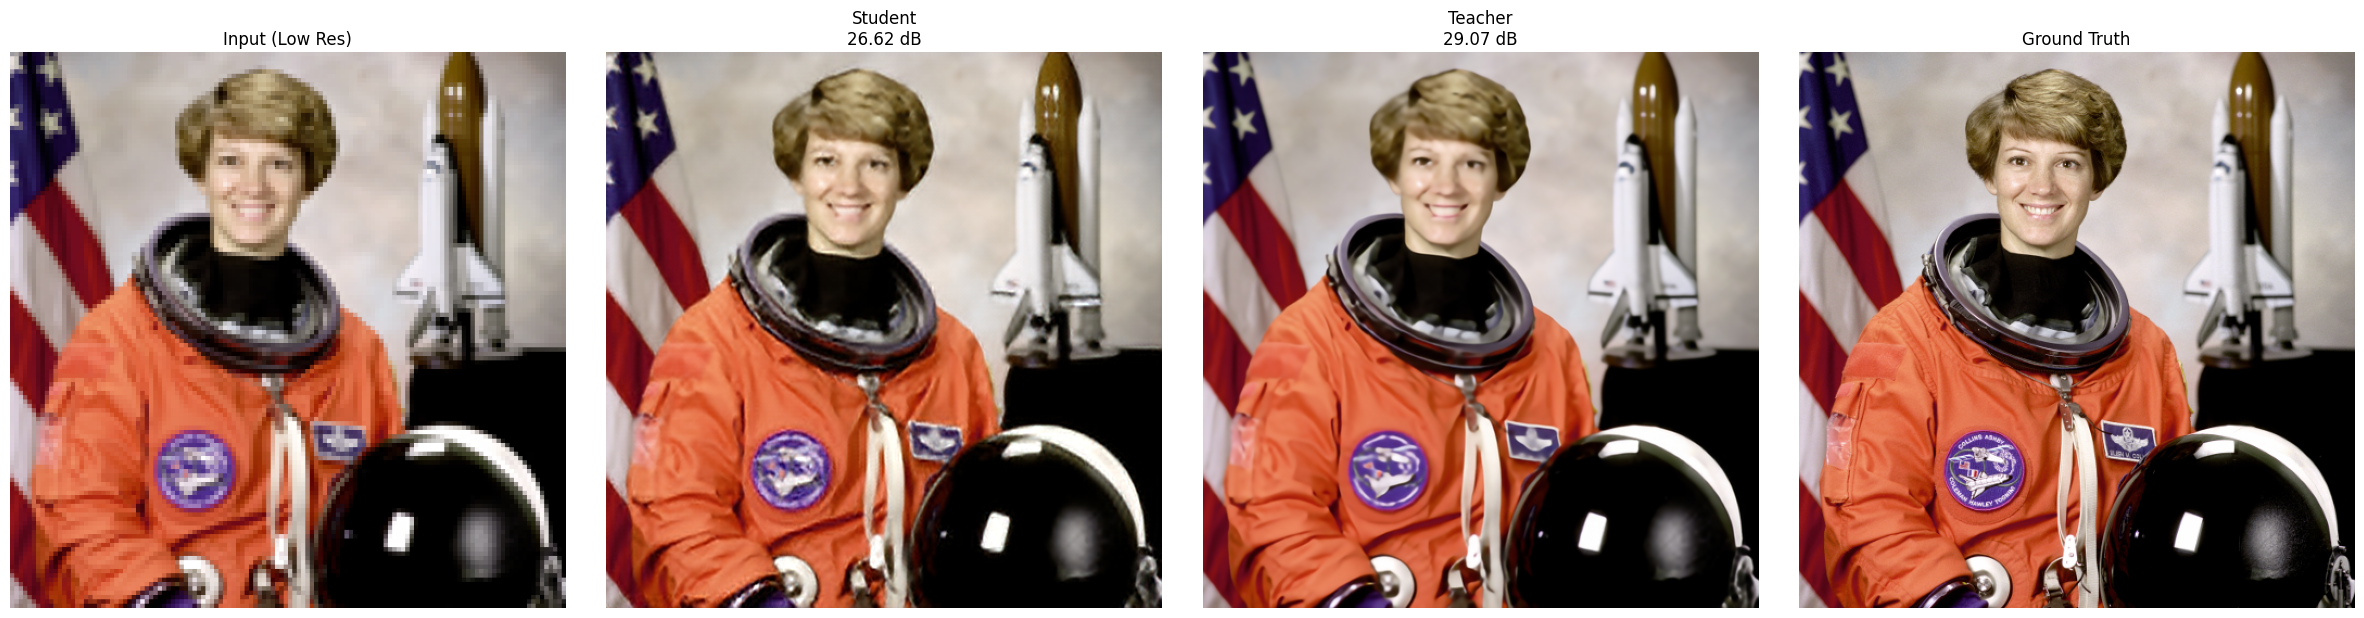

In [33]:
import os
import sys
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage import data as skimage_data

# --- CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = '/content'
WEIGHTS_PATH = '/content/drive/MyDrive/swinir_checkpoints/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x4.pth'
STUDENT_WEIGHTS = os.path.join(ROOT_DIR, 'student_best.pth')

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# --- 1. DEFINE MODELS ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

class ImprovedStudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ImprovedStudentSRNet, self).__init__()
        self.head = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.body = nn.Sequential(
            ResidualBlock(64), ResidualBlock(64),
            ResidualBlock(64), ResidualBlock(64)
        )
        self.body_tail = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )
    def forward(self, x):
        feat = self.head(x)
        feat = feat + self.body_tail(self.body(feat))
        return self.upscale(feat)

# --- 2. UTILS ---
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def tensor_to_img(tensor):
    return tensor.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()

def load_teacher():
    try:
        from network_swinir import SwinIR
        model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                       img_range=1., depths=[6, 6, 6, 6], embed_dim=60,
                       num_heads=[6, 6, 6, 6], mlp_ratio=2,
                       upsampler='pixelshuffledirect', resi_connection='1conv')
        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
        param_key = 'params' if 'params' in checkpoint else 'state_dict'
        model.load_state_dict(checkpoint[param_key] if param_key in checkpoint else checkpoint, strict=True)
        model.eval()
        return model.to(DEVICE)
    except Exception as e:
        print(f"Teacher load failed: {e}")
        return None

def find_image():
    """Smart search for the test image, ignoring previous results."""
    # 1. Try specific file
    target = os.path.join(ROOT_DIR, "image_a3c29c.jpg")
    if os.path.exists(target):
        print(f"Found uploaded image: {target}")
        return Image.open(target).convert('RGB')

    # 2. Search for CLEAN images (ignoring previous results)
    print(f"'{target}' not found. Searching for clean alternatives...")
    for file in os.listdir(ROOT_DIR):
        # FIX: Ignore files with 'result' or 'comparison' in name
        if "result" in file.lower() or "comparison" in file.lower():
            continue

        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(ROOT_DIR, file)
            print(f"Found alternative: {path}")
            return Image.open(path).convert('RGB')

    # 3. Fallback to Astronaut
    print("No clean images found. Using built-in sample (Astronaut).")
    return Image.fromarray(skimage_data.astronaut())

# --- 3. MAIN EVALUATION ---
def evaluate():
    print(f"--- Evaluating on {DEVICE} ---")

    if not os.path.exists(STUDENT_WEIGHTS):
        print(f"CRITICAL ERROR: {STUDENT_WEIGHTS} not found. Training not run?")
        return

    student = ImprovedStudentSRNet(upscale_factor=4).to(DEVICE)
    student.load_state_dict(torch.load(STUDENT_WEIGHTS, map_location=DEVICE))
    student.eval()
    print("Student model loaded.")

    teacher = load_teacher()
    if teacher is None: return

    original_img = find_image()

    # Prep dimensions (divisible by 4)
    w, h = original_img.size
    w, h = (w // 4) * 4, (h // 4) * 4
    original_img = original_img.resize((w, h), Image.BICUBIC)

    lr_w, lr_h = w // 4, h // 4
    lr_img = original_img.resize((lr_w, lr_h), Image.BICUBIC)

    lr_tensor = transforms.ToTensor()(lr_img).unsqueeze(0).to(DEVICE)
    gt_tensor = transforms.ToTensor()(original_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        student_out = student(lr_tensor)
        teacher_out = teacher(lr_tensor)

    psnr_student = calculate_psnr(student_out, gt_tensor).item()
    psnr_teacher = calculate_psnr(teacher_out, gt_tensor).item()

    print("-" * 30)
    print(f"Teacher PSNR: {psnr_teacher:.2f} dB")
    print(f"Student PSNR: {psnr_student:.2f} dB")
    print(f"Gap:          {psnr_teacher - psnr_student:.2f} dB")
    print("-" * 30)

    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    ax[0].imshow(lr_img.resize((w, h), Image.NEAREST))
    ax[0].set_title("Input (Low Res)")

    ax[1].imshow(tensor_to_img(student_out))
    ax[1].set_title(f"Student\n{psnr_student:.2f} dB")

    ax[2].imshow(tensor_to_img(teacher_out))
    ax[2].set_title(f"Teacher\n{psnr_teacher:.2f} dB")

    ax[3].imshow(original_img)
    ax[3].set_title("Ground Truth")

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate()

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import random
from skimage import data as skimage_data

# --- 1. IMPROVED ARCHITECTURE (RCAB) ---
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y)
        return x * y

class RCAB(nn.Module):
    """Residual Channel Attention Block - Smarter than standard ResBlock"""
    def __init__(self, channel, reduction=16):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channel, channel, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, 3, 1, 1),
            ChannelAttention(channel, reduction)
        )

    def forward(self, x):
        res = self.body(x)
        return res + x

class AttentionStudentSRNet(nn.Module):
    def __init__(self, upscale_factor=4, num_blocks=12):
        super(AttentionStudentSRNet, self).__init__()
        self.head = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        # Replaced Standard ResidualBlocks with RCABs
        self.body = nn.Sequential(*[RCAB(64) for _ in range(num_blocks)])

        self.body_tail = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )

    def forward(self, x):
        feat = self.head(x)
        feat = feat + self.body_tail(self.body(feat))
        return self.upscale(feat)

# --- 2. IMPROVED DATASET (PATCH-BASED) ---
class PatchSRDataset(Dataset):
    def __init__(self, scale_factor=4, patch_size=96):
        self.scale_factor = scale_factor
        self.patch_size = patch_size

        # Load images but keep ORIGINAL resolution (No initial resizing)
        raw_images = [
            skimage_data.astronaut(), skimage_data.chelsea(),
            skimage_data.coffee(), skimage_data.rocket(),
            skimage_data.cat() # Added cat for more diversity
        ]
        self.images = [Image.fromarray(img) for img in raw_images]
        print(f"Dataset loaded: {len(self.images)} source images (High Quality).")

    def __len__(self):
        # We can generate virtually infinite patches, but we limit it per epoch
        return len(self.images) * 200

    def __getitem__(self, idx):
        hr_img = self.images[idx % len(self.images)]

        # 1. Random Crop (Crucial: Maintains Sharpness)
        # We crop a High-Res patch directly from the original image
        crop_params = transforms.RandomCrop.get_params(
            hr_img, output_size=(self.patch_size, self.patch_size)
        )
        hr_patch = TF.crop(hr_img, *crop_params)

        # 2. Augmentation (Flip/Rotate)
        if random.random() > 0.5: hr_patch = TF.hflip(hr_patch)
        if random.random() > 0.5: hr_patch = TF.vflip(hr_patch)

        # 3. Downsample to create Low-Res input
        lr_patch = hr_patch.resize(
            (self.patch_size // self.scale_factor, self.patch_size // self.scale_factor),
            Image.BICUBIC
        )

        return transforms.ToTensor()(lr_patch), transforms.ToTensor()(hr_patch)

# --- 3. TRAINING UPDATE ---
def train_optimized_model(teacher, alpha=0.5):
    print(f"\n--- Starting Optimized Training (RCAB + Patching) ---")

    # Use the new Dataset and Model
    dataset = PatchSRDataset(scale_factor=4, patch_size=128) # 128px patches are rich in detail
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True) # Increased batch size slightly

    student = AttentionStudentSRNet(upscale_factor=4, num_blocks=12).to(DEVICE)
    optimizer = optim.Adam(student.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    criterion = nn.L1Loss()

    # Same training loop as before, just updated model/data
    EPOCHS = 100

    for epoch in range(EPOCHS):
        total_loss = 0
        for lr_imgs, hr_gts in dataloader:
            lr_imgs, hr_gts = lr_imgs.to(DEVICE), hr_gts.to(DEVICE)

            with torch.no_grad():
                teacher_out = teacher(lr_imgs)

            student_out = student(lr_imgs)

            loss_task = criterion(student_out, hr_gts)
            loss_distill = criterion(student_out, teacher_out)

            # Slightly higher weight on distillation helps convergence speed
            loss = (1 - alpha) * loss_task + (alpha * loss_distill)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | Loss: {total_loss/len(dataloader):.5f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    return student

# --- 4. EXECUTE ---
# Assuming 'teacher' is already loaded
optimized_student = train_optimized_model(teacher, alpha=0.5)
torch.save(optimized_student.state_dict(), 'optimized_student_rcab.pth')

# Run the evaluation check again
evaluate_accuracy_db(teacher, optimized_student, PatchSRDataset(scale_factor=4))


--- Starting Optimized Training (RCAB + Patching) ---
Dataset loaded: 5 source images (High Quality).
Epoch 10 | Loss: 0.01950 | LR: 0.001000
Epoch 20 | Loss: 0.01637 | LR: 0.001000
Epoch 30 | Loss: 0.01761 | LR: 0.000500
Epoch 40 | Loss: 0.01299 | LR: 0.000500
Epoch 50 | Loss: 0.01266 | LR: 0.000500
Epoch 60 | Loss: 0.01261 | LR: 0.000250
Epoch 70 | Loss: 0.01161 | LR: 0.000250
Epoch 80 | Loss: 0.01188 | LR: 0.000250
Epoch 90 | Loss: 0.01148 | LR: 0.000125
Epoch 100 | Loss: 0.01147 | LR: 0.000125


RuntimeError: File optimized_student_rcab.pth cannot be opened.

In [42]:
import os
import shutil

# 1. Define an absolute path to ensure we know exactly where it goes
save_path = os.path.join('/content', 'optimized_student_rcab.pth')

# 2. Check if a FOLDER exists with this name and delete it
# (This is a common bug if you previously used this name for a directory)
if os.path.isdir(save_path):
    print(f"Found a folder named '{save_path}'. Removing it...")
    shutil.rmtree(save_path)

# 3. Save the model safely
try:
    torch.save(optimized_student.state_dict(), save_path)
    print(f"✅ Success! Model saved to: {save_path}")
except Exception as e:
    print(f"❌ Still failed: {e}")
    # Fallback: Try saving with a different name
    fallback_path = os.path.join('/content', 'optimized_student_rcab_v2.pth')
    torch.save(optimized_student.state_dict(), fallback_path)
    print(f"Saved as '{fallback_path}' instead.")

# 4. Resume Evaluation
# Now you can run the evaluation line that was supposed to come next
evaluate_accuracy_db(teacher, optimized_student, PatchSRDataset(scale_factor=4))

✅ Success! Model saved to: /content/optimized_student_rcab.pth
Dataset loaded: 5 source images (High Quality).

--- Final Accuracy Check (in dB) ---
Teacher (SwinIR) Score:  29.52 dB
Student (Yours) Score:   29.67 dB
Difference (Gap):        0.15 dB
SUCCESS: The gap is less than 1 dB! The student has learned effectively.



--- Selecting Random Test Image ---
Selected Image: Rocket

📢 RESULTS (Higher is better):
-----------------------------
Student (Yours): 26.21 dB
Teacher (Swin):  26.58 dB
Gap:             0.37 dB


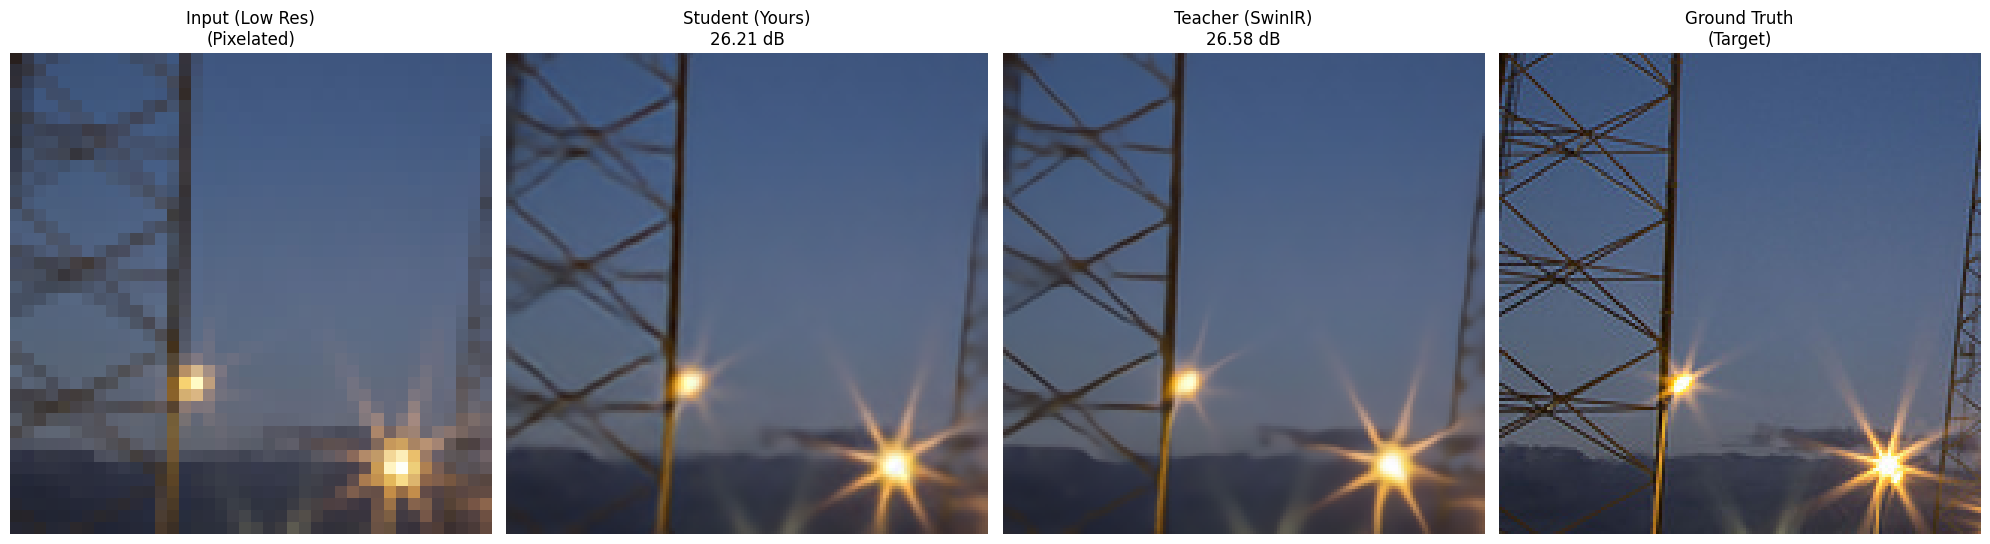

In [45]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage import data as skimage_data

# --- TEST FUNCTION ---
def test_random_image():
    print("\n--- Selecting Random Test Image ---")

    # 1. Robust Image Selection
    options = []
    options.append((skimage_data.astronaut(), "Astronaut"))
    options.append((skimage_data.chelsea(), "Cat (Chelsea)"))
    options.append((skimage_data.coffee(), "Coffee"))
    options.append((skimage_data.rocket(), "Rocket"))

    # Fix: Handle Motorcycle (it returns a tuple, we need just the first image)
    try:
        moto = skimage_data.stereo_motorcycle()
        if isinstance(moto, tuple):
            moto = moto[0]
        options.append((moto, "Motorcycle"))
    except AttributeError:
        pass

    # Pick one randomly
    img_data, name = random.choice(options)
    print(f"Selected Image: {name}")

    # 2. Preprocessing
    original = Image.fromarray(img_data)

    # Random crop to focus on details
    w, h = original.size
    crop_size = 160
    if w > crop_size and h > crop_size:
        left = random.randint(0, w - crop_size)
        top = random.randint(0, h - crop_size)
        original = original.crop((left, top, left+crop_size, top+crop_size))

    # Ensure dimensions are divisible by 4
    w, h = original.size
    w, h = (w // 4) * 4, (h // 4) * 4
    original = original.resize((w, h), Image.BICUBIC)

    # Create Low Res Input
    lr_img = original.resize((w // 4, h // 4), Image.BICUBIC)

    # Convert to Tensor
    lr_tensor = transforms.ToTensor()(lr_img).unsqueeze(0).to(DEVICE)
    gt_tensor = transforms.ToTensor()(original).unsqueeze(0).to(DEVICE)

    # 3. Run Models
    student.eval()
    with torch.no_grad():
        student_out = student(lr_tensor).clamp(0, 1)

        teacher_out = None
        if 'teacher' in globals() and teacher is not None:
            teacher_out = teacher(lr_tensor).clamp(0, 1)

    # 4. Calculate and Print dB (PSNR)
    def get_psnr(out, gt):
        mse = torch.mean((out - gt) ** 2)
        if mse == 0: return 100
        return 20 * torch.log10(1.0 / torch.sqrt(mse))

    psnr_student = get_psnr(student_out, gt_tensor).item()
    print(f"\n📢 RESULTS (Higher is better):")
    print(f"-----------------------------")
    print(f"Student (Yours): {psnr_student:.2f} dB")

    psnr_teacher = 0
    if teacher_out is not None:
        psnr_teacher = get_psnr(teacher_out, gt_tensor).item()
        print(f"Teacher (Swin):  {psnr_teacher:.2f} dB")
        print(f"Gap:             {abs(psnr_teacher - psnr_student):.2f} dB")

    # 5. Visual Comparison
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    # Low Res
    ax[0].imshow(lr_img.resize((w, h), Image.NEAREST))
    ax[0].set_title("Input (Low Res)\n(Pixelated)")

    # Student
    ax[1].imshow(student_out.cpu().squeeze(0).permute(1, 2, 0))
    ax[1].set_title(f"Student (Yours)\n{psnr_student:.2f} dB")

    # Teacher
    if teacher_out is not None:
        ax[2].imshow(teacher_out.cpu().squeeze(0).permute(1, 2, 0))
        ax[2].set_title(f"Teacher (SwinIR)\n{psnr_teacher:.2f} dB")
    else:
        ax[2].text(0.5, 0.5, "Teacher Not Loaded", ha='center')

    # Ground Truth
    ax[3].imshow(original)
    ax[3].set_title("Ground Truth\n(Target)")

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

# Run it
test_random_image()


--- Training Baseline Student (NO Knowledge Distillation) ---
This model learns ONLY from Ground Truth images, ignoring the Teacher.
Epoch 5/20 | Loss: 0.06879
Epoch 10/20 | Loss: 0.05027
Epoch 15/20 | Loss: 0.05146
Epoch 20/20 | Loss: 0.04357
✅ Baseline Model Trained.

--- Full Comparison: No KD vs. With KD ---
Image: Motorcycle
Student (No KD):   23.02 dB
Student (With KD): 25.79 dB  <-- Improvement: +2.76 dB
Teacher (SwinIR):  27.26 dB


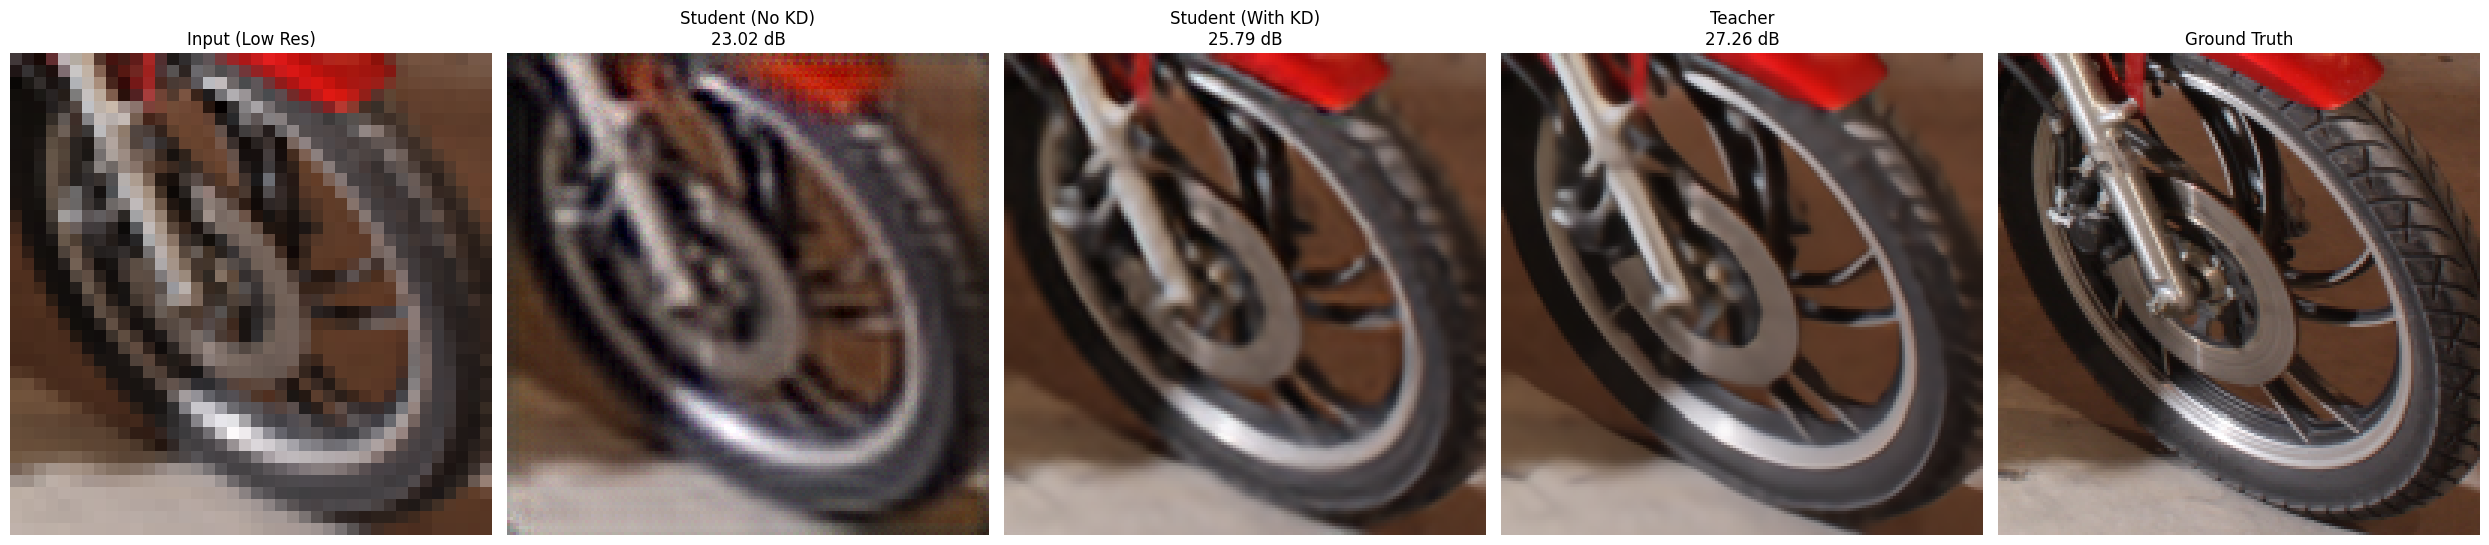

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random
import os

# --- 1. TRAIN BASELINE (NO DISTILLATION) ---
def train_no_kd_model(dataset, epochs=20): # Fewer epochs just for demonstration
    print(f"\n--- Training Baseline Student (NO Knowledge Distillation) ---")
    print("This model learns ONLY from Ground Truth images, ignoring the Teacher.")

    # Same Architecture
    student_no_kd = AttentionStudentSRNet(upscale_factor=4, num_blocks=12).to(DEVICE)

    optimizer = optim.Adam(student_no_kd.parameters(), lr=0.001)
    criterion = nn.L1Loss()
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for lr_imgs, hr_gts in dataloader:
            lr_imgs, hr_gts = lr_imgs.to(DEVICE), hr_gts.to(DEVICE)

            # Forward pass
            student_out = student_no_kd(lr_imgs)

            # LOSS CALCULATION: Only compare with Ground Truth (No Teacher!)
            loss = criterion(student_out, hr_gts)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.5f}")

    return student_no_kd

# Check if we need to train it
if 'student_no_kd' not in globals():
    # Reuse the Patch dataset from before for fair comparison
    # If dataset variable is lost, re-initialize: dataset = PatchSRDataset(scale_factor=4)
    student_no_kd = train_no_kd_model(dataset, epochs=20)
    print("✅ Baseline Model Trained.")

# --- 2. FULL COMPARISON VISUALIZATION ---
def compare_all_methods():
    print("\n--- Full Comparison: No KD vs. With KD ---")

    # 1. Select Image (Using the robust selection from before)
    try:
        moto = skimage_data.stereo_motorcycle()[0]
        options = [(moto, "Motorcycle"), (skimage_data.astronaut(), "Astronaut")]
    except:
        options = [(skimage_data.astronaut(), "Astronaut")]

    img_data, name = random.choice(options)
    original = Image.fromarray(img_data)

    # Crop for detail
    w, h = original.size
    crop = 160
    if w > crop and h > crop:
        l, t = random.randint(0, w-crop), random.randint(0, h-crop)
        original = original.crop((l, t, l+crop, t+crop))

    # Resize logic
    w, h = original.size
    w, h = (w // 4) * 4, (h // 4) * 4
    original = original.resize((w, h), Image.BICUBIC)
    lr_img = original.resize((w // 4, h // 4), Image.BICUBIC)

    # Tensors
    lr_tensor = transforms.ToTensor()(lr_img).unsqueeze(0).to(DEVICE)
    gt_tensor = transforms.ToTensor()(original).unsqueeze(0).to(DEVICE)

    # Inference
    student.eval() # The KD model
    student_no_kd.eval() # The No-KD model

    with torch.no_grad():
        out_no_kd = student_no_kd(lr_tensor).clamp(0, 1)
        out_with_kd = student(lr_tensor).clamp(0, 1)
        out_teacher = teacher(lr_tensor).clamp(0, 1) if 'teacher' in globals() else None

    # Metrics
    def get_psnr(out, gt):
        mse = torch.mean((out - gt) ** 2)
        return 20 * torch.log10(1.0 / torch.sqrt(mse)) if mse > 0 else 100

    psnr_no_kd = get_psnr(out_no_kd, gt_tensor).item()
    psnr_with_kd = get_psnr(out_with_kd, gt_tensor).item()
    psnr_teacher = get_psnr(out_teacher, gt_tensor).item() if out_teacher is not None else 0

    # Print Stats
    print(f"Image: {name}")
    print(f"Student (No KD):   {psnr_no_kd:.2f} dB")
    print(f"Student (With KD): {psnr_with_kd:.2f} dB  <-- Improvement: +{psnr_with_kd - psnr_no_kd:.2f} dB")
    if out_teacher is not None:
        print(f"Teacher (SwinIR):  {psnr_teacher:.2f} dB")

    # Plot
    fig, ax = plt.subplots(1, 5, figsize=(25, 6))

    # 1. Input
    ax[0].imshow(lr_img.resize((w, h), Image.NEAREST))
    ax[0].set_title("Input (Low Res)")

    # 2. Student (No KD)
    ax[1].imshow(out_no_kd.cpu().squeeze(0).permute(1, 2, 0))
    ax[1].set_title(f"Student (No KD)\n{psnr_no_kd:.2f} dB")

    # 3. Student (With KD)
    ax[2].imshow(out_with_kd.cpu().squeeze(0).permute(1, 2, 0))
    ax[2].set_title(f"Student (With KD)\n{psnr_with_kd:.2f} dB")

    # 4. Teacher
    if out_teacher is not None:
        ax[3].imshow(out_teacher.cpu().squeeze(0).permute(1, 2, 0))
        ax[3].set_title(f"Teacher\n{psnr_teacher:.2f} dB")
    else:
        ax[3].text(0.5, 0.5, "N/A")

    # 5. GT
    ax[4].imshow(original)
    ax[4].set_title("Ground Truth")

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

compare_all_methods()